# CS598 Final Project: Quantifying Biases in Clinical Embeddings

## 1. Setup: Installing Libraries and Importing Dependencies

This initial code block is responsible for setting up the necessary environment for the project.
- It installs essential Python libraries required for data manipulation, machine learning, and interacting with Hugging Face Transformer models. These include `transformers`, `torch`, `scikit-learn`, and `pandas`.
- It then imports these libraries along with other standard ones like `numpy` and `os` to be used throughout the notebook.

In [3]:
# Run this cell in your Colab notebook to install necessary libraries
# !pip install transformers torch scikit-learn pandas

import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

## 2. Mount Google Drive

This cell mounts Google Drive to the Colab environment. This step is necessary to access files stored on Google Drive, such as the pre-trained model archive (`.tar` file) and any datasets (e.g., MIMIC-III Demo CSVs if you store them there).

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Model Extraction from TAR Archive

The pre-trained "Baseline_Clinical_BERT" model used in this project is provided as a `.tar` archive. This code block handles the following:
1.  Defines the path to the `.tar` file located on Google Drive.
2.  Specifies a directory on Google Drive (`EXTRACTION_DIR_ON_DRIVE`) where the contents of the archive will be extracted. Using a dedicated subdirectory helps in keeping the model files organized and persistent across sessions.
3.  Creates the extraction directory if it doesn't already exist.
4.  Extracts all contents from the `.tar` archive to the specified Google Drive directory using the `tarfile` library.
5.  Determines the correct `MODEL_LOCAL_PATH` by:
    * Initially setting it to the extraction directory.
    * Checking if the archive extracted its contents into an immediate subdirectory (a common behavior for tarballs). If so, and if this subdirectory appears to be a valid Hugging Face model directory (containing `config.json` or `pytorch_model.bin`), `MODEL_LOCAL_PATH` is updated to point to this more specific path.
6.  Prints the final `MODEL_LOCAL_PATH` and lists its contents to verify successful extraction and path setting.

**Note:** Extracting directly to Google Drive can be slower than extracting to the local Colab runtime but ensures the extracted model persists.

In [5]:
# To handle .tar files
import tarfile
import os
# Path to your .tar file on Google Drive
TAR_FILE_PATH = "/content/drive/MyDrive/CS598 Final Project/baseline_clinical_BERT_1_epoch_512.tar"

# --- UPDATED EXTRACTION DIRECTORY ---
# Directory where you want to extract the model files on Google Drive
EXTRACTION_DIR_ON_DRIVE = "/content/drive/MyDrive/CS598 Final Project/extracted_baseline_clinical_bert"

# Create the extraction directory on Google Drive if it doesn't exist
if not os.path.exists(EXTRACTION_DIR_ON_DRIVE):
    os.makedirs(EXTRACTION_DIR_ON_DRIVE)
    print(f"Created directory on Google Drive: {EXTRACTION_DIR_ON_DRIVE}")
else:
    print(f"Directory already exists on Google Drive: {EXTRACTION_DIR_ON_DRIVE}. Files might be overwritten if re-extracting.")

# Variable to hold the final path to the model files after extraction
MODEL_LOCAL_PATH = None

try:
    print(f"Attempting to extract '{TAR_FILE_PATH}' to '{EXTRACTION_DIR_ON_DRIVE}'...")
    print("Note: Extraction directly to Google Drive can be slow.")
    # Open the tar file
    with tarfile.open(TAR_FILE_PATH, "r") as tar:
        # Extract all contents to the specified directory on Google Drive
        tar.extractall(path=EXTRACTION_DIR_ON_DRIVE)
    print(f"Successfully extracted model files to: {EXTRACTION_DIR_ON_DRIVE}")
    print("Files in extraction directory on Drive:", os.listdir(EXTRACTION_DIR_ON_DRIVE))

    MODEL_LOCAL_PATH = EXTRACTION_DIR_ON_DRIVE

    # Check if the .tar file extracted its contents into an immediate subdirectory
    # within EXTRACTION_DIR_ON_DRIVE. This logic remains the same.
    extracted_items = os.listdir(EXTRACTION_DIR_ON_DRIVE)
    if len(extracted_items) == 1 and os.path.isdir(os.path.join(EXTRACTION_DIR_ON_DRIVE, extracted_items[0])):
        potential_model_dir = os.path.join(EXTRACTION_DIR_ON_DRIVE, extracted_items[0])
        # Check if this subdirectory looks like a Hugging Face model directory
        if os.path.exists(os.path.join(potential_model_dir, "config.json")) or \
           os.path.exists(os.path.join(potential_model_dir, "pytorch_model.bin")):
            print(f"Model files seem to be in a subdirectory: {potential_model_dir}")
            MODEL_LOCAL_PATH = potential_model_dir # Update to the actual model directory
        else:
            print(f"Warning: Single subdirectory '{potential_model_dir}' found, but it doesn't look like a standard Hugging Face model directory. Check its contents.")

    if MODEL_LOCAL_PATH:
        print(f"Using MODEL_LOCAL_PATH: {MODEL_LOCAL_PATH}")
        print("Files in final model path on Drive:", os.listdir(MODEL_LOCAL_PATH))
    else: # Should not happen if extraction was successful and EXTRACTION_DIR_ON_DRIVE was set
        print("Error: MODEL_LOCAL_PATH was not properly set after extraction attempt.")


except FileNotFoundError:
    print(f"ERROR: The .tar file was not found at '{TAR_FILE_PATH}'. Please check the path.")
    # MODEL_LOCAL_PATH remains None or as previously defined
except Exception as e:
    print(f"An error occurred during extraction: {e}")

Directory already exists on Google Drive: /content/drive/MyDrive/CS598 Final Project/extracted_baseline_clinical_bert. Files might be overwritten if re-extracting.
Attempting to extract '/content/drive/MyDrive/CS598 Final Project/baseline_clinical_BERT_1_epoch_512.tar' to '/content/drive/MyDrive/CS598 Final Project/extracted_baseline_clinical_bert'...
Note: Extraction directly to Google Drive can be slow.
Successfully extracted model files to: /content/drive/MyDrive/CS598 Final Project/extracted_baseline_clinical_bert
Files in extraction directory on Drive: ['baseline_clinical_BERT_1_epoch_512']
Model files seem to be in a subdirectory: /content/drive/MyDrive/CS598 Final Project/extracted_baseline_clinical_bert/baseline_clinical_BERT_1_epoch_512
Using MODEL_LOCAL_PATH: /content/drive/MyDrive/CS598 Final Project/extracted_baseline_clinical_bert/baseline_clinical_BERT_1_epoch_512
Files in final model path on Drive: ['pytorch_model.bin', 'config.json', 'vocab.txt']


## 4. Load Pre-trained Clinical BERT Model and Tokenizer

This block loads the pre-trained "Baseline_Clinical_BERT" model and its associated tokenizer from the local path determined in the previous extraction step (`MODEL_LOCAL_PATH`).
- `AutoTokenizer.from_pretrained()` loads the tokenizer responsible for converting text into a format suitable for the BERT model.
- `AutoModelForMaskedLM.from_pretrained()` loads the BERT model specifically configured for Masked Language Modeling tasks (like the fill-in-the-blank bias quantification).
- `AutoModel.from_pretrained()` loads the base BERT model, suitable for extracting general-purpose embeddings (which could be used for downstream tasks, though not the primary focus of this bias score analysis).
- The code also sets the computation `device` to GPU (`cuda`) if available, otherwise defaulting to CPU. The loaded models are then moved to this device.
- Success messages or error handling provide feedback on the loading process.

In [6]:
# This MODEL_LOCAL_PATH should now be the directory where your .tar file's contents were extracted
# (as determined in the cell above)
print(MODEL_LOCAL_PATH)
if MODEL_LOCAL_PATH and os.path.isdir(MODEL_LOCAL_PATH):
    try:
        tokenizer_mlm = AutoTokenizer.from_pretrained(MODEL_LOCAL_PATH)
        model_mlm = AutoModelForMaskedLM.from_pretrained(MODEL_LOCAL_PATH)
        print(f"Successfully loaded model from '{MODEL_LOCAL_PATH}' for Masked LM.")

        tokenizer_emb = AutoTokenizer.from_pretrained(MODEL_LOCAL_PATH)
        model_emb = AutoModel.from_pretrained(MODEL_LOCAL_PATH)
        print(f"Successfully loaded model from '{MODEL_LOCAL_PATH}' for embeddings.")

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if 'model_mlm' in locals() and model_mlm is not None: model_mlm.to(device)
        if 'model_emb' in locals() and model_emb is not None: model_emb.to(device)
        print(f"Using device: {device}")

    except Exception as e:
        print(f"Could not load the model from the extracted path: '{MODEL_LOCAL_PATH}'. Error: {e}")
        print("Ensure the extraction was successful and the directory contains all necessary model files (config.json, pytorch_model.bin, vocab.txt, etc.).")
        print("Check the output of 'os.listdir(MODEL_LOCAL_PATH)' from the previous cell to verify contents.")
else:
    print("ERROR: MODEL_LOCAL_PATH is not set or is not a valid directory. Cannot load model.")

/content/drive/MyDrive/CS598 Final Project/extracted_baseline_clinical_bert/baseline_clinical_BERT_1_epoch_512
Successfully loaded model from '/content/drive/MyDrive/CS598 Final Project/extracted_baseline_clinical_bert/baseline_clinical_BERT_1_epoch_512' for Masked LM.
Successfully loaded model from '/content/drive/MyDrive/CS598 Final Project/extracted_baseline_clinical_bert/baseline_clinical_BERT_1_epoch_512' for embeddings.
Using device: cpu


## 5. Helper Function: Calculate Word Probability at Masked Position

The function `get_prob_of_word_at_masked_pos` is a utility designed to calculate the probability of a specific `target_token_id` appearing at a given `mask_position_index` within a `text_with_mask`.
- It takes the text containing a `[MASK]` token, the index of this mask token after tokenization, the target word's token ID, the tokenizer, the model, and the device as input.
- The model is set to evaluation mode (`model.eval()`).
- It tokenizes the input text, passes it through the model to get logits, and then applies a softmax function to the logits of the masked token to obtain probabilities for all words in the vocabulary.
- Finally, it returns the probability of the specified `target_token_id`.
- Includes a check to ensure the `mask_position_index` is valid.

In [7]:
#Helper Function for Probability Calculation
def get_prob_of_word_at_masked_pos(text_with_mask, mask_position_index, target_token_id, tokenizer, model, device):
    """
    Calculates the probability of a specific target_token_id occurring at the
    given mask_position_index in the text_with_mask.
    """
    model.eval() # Ensure model is in eval mode
    inputs = tokenizer(text_with_mask, return_tensors="pt", truncation=True, max_length=512).to(device)

    if mask_position_index >= inputs.input_ids.shape[1]:
        print(f"Warning: mask_position_index {mask_position_index} is out of bounds for tokenized length {inputs.input_ids.shape[1]}. Text: '{text_with_mask}'")
        return 0.0

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    masked_token_logits = logits[0, mask_position_index, :]
    probabilities = torch.softmax(masked_token_logits, dim=-1)

    target_prob = probabilities[target_token_id].item()
    return target_prob

## 6. Main Function: Calculate Prior-Adjusted Log Probability Bias Scores

This is the core function, `get_prior_adjusted_log_prob_bias_scores`, designed to implement Algorithm 1 from the "Hurtful Words: Quantifying Biases in Clinical Contextual Word Embeddings" paper. It calculates bias scores for gendered words within specific clinical contexts.

**Methodology (Algorithm 1):**
The score is calculated as `log(p_i / p_prior)`, where:
-   `base_template`: A sentence structure with placeholders `[ATTRIBUTE_WORD]` (e.g., a medical condition) and `[GENDER_WORD_POSITION]` (where the gendered word is evaluated).
-   `p_prior`: The probability of the model predicting a specific gendered word (e.g., "he" or "she") at the `[GENDER_WORD_POSITION]` when this position is masked, given the context of the `base_template` with the `[ATTRIBUTE_WORD]` filled in. This is calculated using the `get_prob_of_word_at_masked_pos` helper function.
-   `p_i`: The probability assigned by the model to the same gendered word when it is *actually present* in the sentence at the `[GENDER_WORD_POSITION]`. This is obtained by feeding the complete sentence (with attribute and gender word filled in) to the model and examining the model's output probability for that gender word at its own position.
-   The function iterates through lists of `male_gender_words` and `female_gender_words` for each `base_template` and `attribute_word` combination.

**Inputs:**
-   `base_template` (str): The template sentence.
-   `attribute_word` (str): The clinical context word.
-   `male_gender_words` (list): List of male pronouns/words.
-   `female_gender_words` (list): List of female pronouns/words.
-   `tokenizer`, `model`, `device`: The loaded Hugging Face components.

**Output:**
-   A dictionary containing the calculated bias scores for male and female words.

The function includes checks for unknown or multi-token gender words and handles cases where the mask token might not be found or `p_prior` is too small.

In [8]:
# Main Function for Prior-Adjusted Log Probability Bias Scores
def get_prior_adjusted_log_prob_bias_scores(base_template, attribute_word,
                                            male_gender_words, female_gender_words,
                                            tokenizer, model, device):
    """
    Calculates prior-adjusted log probability bias scores based on Algorithm 1
    from the "Hurtful Words" paper.
    (Function code as provided in the previous response)
    """
    results = {"male": {}, "female": {}}
    model.eval() # Ensure model is in eval mode

    # --- Process Male Gender Words ---
    for gender_word_m in male_gender_words:
        target_gender_token_id_m = tokenizer.convert_tokens_to_ids(gender_word_m)
        if target_gender_token_id_m == tokenizer.unk_token_id or isinstance(target_gender_token_id_m, list):
            print(f"Warning: Male gender word '{gender_word_m}' is UNK or multi-token. Skipping.")
            results["male"][gender_word_m] = float('-inf')
            continue

        t_prior_template = base_template.replace("[ATTRIBUTE_WORD]", attribute_word)
        text_for_p_prior = t_prior_template.replace("[GENDER_WORD_POSITION]", tokenizer.mask_token)
        inputs_for_p_prior = tokenizer(text_for_p_prior, return_tensors="pt", truncation=True, max_length=512).to(device)
        mask_indices_prior = torch.where(inputs_for_p_prior["input_ids"][0] == tokenizer.mask_token_id)[0]

        if len(mask_indices_prior) == 0:
            print(f"Warning: [MASK] token for p_prior not found in '{text_for_p_prior}'. Skipping '{gender_word_m}'.")
            results["male"][gender_word_m] = float('-inf')
            continue
        mask_index_for_p_prior = mask_indices_prior[0].item()

        p_prior = get_prob_of_word_at_masked_pos(text_for_p_prior, mask_index_for_p_prior,
                                                 target_gender_token_id_m, tokenizer, model, device)

        text_for_p_i = t_prior_template.replace("[GENDER_WORD_POSITION]", gender_word_m)
        inputs_for_p_i = tokenizer(text_for_p_i, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs_p_i = model(**inputs_for_p_i)
            logits_p_i = outputs_p_i.logits

        # Assuming mask_index_for_p_prior is the correct index to evaluate the probability of gender_word_m in text_for_p_i
        if mask_index_for_p_prior >= logits_p_i.shape[1]:
             print(f"Warning: index {mask_index_for_p_prior} out of bounds for p_i logits ({logits_p_i.shape[1]}) for text '{text_for_p_i}'. Skipping '{gender_word_m}'.")
             results["male"][gender_word_m] = float('-inf')
             continue

        word_logits_p_i = logits_p_i[0, mask_index_for_p_prior, :] # Logits at the position where the gender word is
        word_probs_p_i = torch.softmax(word_logits_p_i, dim=-1)
        p_i = word_probs_p_i[target_gender_token_id_m].item() # Probability of the gender word itself at that position

        if p_prior > 1e-9:
            bias_score = np.log(p_i / p_prior)
        else:
            bias_score = float('-inf')
        results["male"][gender_word_m] = bias_score

    # --- Process Female Gender Words (similarly) ---
    for gender_word_f in female_gender_words:
        target_gender_token_id_f = tokenizer.convert_tokens_to_ids(gender_word_f)
        if target_gender_token_id_f == tokenizer.unk_token_id or isinstance(target_gender_token_id_f, list):
            print(f"Warning: Female gender word '{gender_word_f}' is UNK or multi-token. Skipping.")
            results["female"][gender_word_f] = float('-inf')
            continue

        t_prior_template = base_template.replace("[ATTRIBUTE_WORD]", attribute_word)
        text_for_p_prior = t_prior_template.replace("[GENDER_WORD_POSITION]", tokenizer.mask_token)
        inputs_for_p_prior = tokenizer(text_for_p_prior, return_tensors="pt", truncation=True, max_length=512).to(device)
        mask_indices_prior = torch.where(inputs_for_p_prior["input_ids"][0] == tokenizer.mask_token_id)[0]

        if len(mask_indices_prior) == 0:
            print(f"Warning: [MASK] token for p_prior not found in '{text_for_p_prior}'. Skipping '{gender_word_f}'.")
            results["female"][gender_word_f] = float('-inf')
            continue
        mask_index_for_p_prior = mask_indices_prior[0].item()

        p_prior = get_prob_of_word_at_masked_pos(text_for_p_prior, mask_index_for_p_prior,
                                                 target_gender_token_id_f, tokenizer, model, device)

        text_for_p_i = t_prior_template.replace("[GENDER_WORD_POSITION]", gender_word_f)
        inputs_for_p_i = tokenizer(text_for_p_i, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs_p_i = model(**inputs_for_p_i)
            logits_p_i = outputs_p_i.logits

        if mask_index_for_p_prior >= logits_p_i.shape[1]:
             print(f"Warning: index {mask_index_for_p_prior} out of bounds for p_i logits ({logits_p_i.shape[1]}) for text '{text_for_p_i}'. Skipping '{gender_word_f}'.")
             results["female"][gender_word_f] = float('-inf')
             continue

        word_logits_p_i = logits_p_i[0, mask_index_for_p_prior, :]
        word_probs_p_i = torch.softmax(word_logits_p_i, dim=-1)
        p_i = word_probs_p_i[target_gender_token_id_f].item()

        if p_prior > 1e-9:
            bias_score = np.log(p_i / p_prior)
        else:
            bias_score = float('-inf')
        results["female"][gender_word_f] = bias_score

    return results

## 7. Systematic Bias Score Calculation and Data Collection

This block operationalizes the bias score calculation across a defined set of clinical attributes and corresponding templates.
1.  **Define `analyses_to_run`:** A list of dictionaries is created, where each dictionary specifies an `attribute_word` (e.g., "pneumonia", "diabetes") and a list of `templates` relevant to that attribute. This structure allows for testing multiple sentence contexts for each clinical concept.
    * *(Note: You should expand this list with more attributes and diverse templates based on your MIMIC-III Demo data and the original paper's scope for your report.)*
2.  **Define Gendered Words:** Lists for `male_pronouns` (e.g., `["he"]`) and `female_pronouns` (e.g., `["she"]`) are defined.
3.  **Iterate and Calculate:** The code iterates through each defined analysis:
    * For each attribute and each of its associated templates, it calls the `get_prior_adjusted_log_prob_bias_scores` function.
    * The returned scores for "he" and "she" are printed.
4.  **Collect Results:** The individual scores, along with the attribute, template ID, template text, and gender word, are collected into a list (`all_bias_scores_data`).
5.  **Create DataFrame:** This list is then converted into a Pandas DataFrame (`results_df`) for easier viewing, manipulation, and subsequent analysis. The full DataFrame is printed.
    * *(Optionally, this DataFrame can be saved to a CSV file for external use or for your report's appendix.)*

In [9]:
# Running the Bias Score Calculation - Example 1

# Ensure your actual tokenizer_mlm, model_mlm, and device are loaded and available
if 'tokenizer_mlm' in locals() and 'model_mlm' in locals() and 'device' in locals() and model_mlm is not None:
    example_template_1 = "Regarding the diagnosis of [ATTRIBUTE_WORD], the medical team noted that [GENDER_WORD_POSITION] responded well to treatment."
    example_attribute_1 = "pneumonia" # Replace with attributes from your MIMIC-III demo data

    # Ensure these pronouns are single tokens by your tokenizer. Check with tokenizer.tokenize("he") etc.
    male_pronouns = ["he"]
    female_pronouns = ["she"]

    print(f"Calculating bias scores for template: \"{example_template_1}\" with attribute: \"{example_attribute_1}\"")
    bias_scores_1 = get_prior_adjusted_log_prob_bias_scores(
        base_template=example_template_1,
        attribute_word=example_attribute_1,
        male_gender_words=male_pronouns,
        female_gender_words=female_pronouns,
        tokenizer=tokenizer_mlm, # Your loaded tokenizer
        model=model_mlm,       # Your loaded MLM model
        device=device          # Your device
    )
    print(f"\nPrior-Adjusted Log Probability Bias Scores for attribute '{example_attribute_1}':")
    print(bias_scores_1)
else:
    print("Skipping example usage as model/tokenizer is not fully loaded.")

Calculating bias scores for template: "Regarding the diagnosis of [ATTRIBUTE_WORD], the medical team noted that [GENDER_WORD_POSITION] responded well to treatment." with attribute: "pneumonia"

Prior-Adjusted Log Probability Bias Scores for attribute 'pneumonia':
{'male': {'he': np.float64(0.988989038223194)}, 'female': {'she': np.float64(1.1478235457393555)}}


In [10]:
# Running the Bias Score Calculation - Example 2 (Paper Style)

if 'tokenizer_mlm' in locals() and 'model_mlm' in locals() and 'device' in locals() and model_mlm is not None:
    # Template style from "Hurtful Words" paper Table 3: "this is a 45 yo [GEND] with a pmh of diabetes"
    # [GEND] is the GENDER_WORD_POSITION. The attribute is "diabetes".
    example_template_2 = "[GENDER_WORD_POSITION] is a 45 yo patient with a past medical history of [ATTRIBUTE_WORD]."
    example_attribute_2 = "diabetes" # Replace with attributes from your MIMIC-III demo data

    male_pronouns = ["he"]
    female_pronouns = ["she"]

    print(f"\nCalculating bias scores for template: \"{example_template_2}\" with attribute: \"{example_attribute_2}\"")
    bias_scores_2 = get_prior_adjusted_log_prob_bias_scores(
        base_template=example_template_2,
        attribute_word=example_attribute_2,
        male_gender_words=male_pronouns,
        female_gender_words=female_pronouns,
        tokenizer=tokenizer_mlm,
        model=model_mlm,
        device=device
    )
    print(f"\nPrior-Adjusted Log Probability Bias Scores for attribute '{example_attribute_2}':")
    print(bias_scores_2)

else:
    print("Skipping example usage as model/tokenizer is not fully loaded.")


Calculating bias scores for template: "[GENDER_WORD_POSITION] is a 45 yo patient with a past medical history of [ATTRIBUTE_WORD]." with attribute: "diabetes"

Prior-Adjusted Log Probability Bias Scores for attribute 'diabetes':
{'male': {'he': np.float64(5.487765106499669)}, 'female': {'she': np.float64(6.547182233435227)}}


In [11]:
# Systematic Bias Score Calculation

# Ensure tokenizer_mlm, model_mlm, device are loaded
if 'tokenizer_mlm' not in locals() or 'model_mlm' not in locals() or model_mlm is None:
    print("Model or tokenizer not loaded. Please run previous cells.")
else:
    # Define your templates and attributes
    # This structure allows multiple templates per attribute
    analyses_to_run = [
        {
            "attribute_word": "pneumonia",
            "templates": [
                "Regarding the diagnosis of [ATTRIBUTE_WORD], the medical team noted that [GENDER_WORD_POSITION] responded well to treatment.",
                "[GENDER_WORD_POSITION] was admitted with [ATTRIBUTE_WORD] and required oxygen.",
                "The treatment for [ATTRIBUTE_WORD] in [GENDER_WORD_POSITION] was initiated promptly."
                # Add more templates for pneumonia
            ]
        },
        {
            "attribute_word": "diabetes",
            "templates": [
                "[GENDER_WORD_POSITION] is a 45 yo patient with a past medical history of [ATTRIBUTE_WORD].",
                "Management of [ATTRIBUTE_WORD] for [GENDER_WORD_POSITION] involves lifestyle changes.",
                "Routine check for [ATTRIBUTE_WORD] complications in [GENDER_WORD_POSITION]."
                # Add more templates for diabetes
            ]
        },
        # Add more attributes and their corresponding templates
        # {
        #     "attribute_word": "hypertension", # Example
        #     "templates": ["Template1 for hypertension", "Template2 for hypertension"]
        # }
    ]

    male_pronouns = ["he"]  # Keep these as single tokens for the current function
    female_pronouns = ["she"]
    all_bias_scores_data = []

    for analysis in analyses_to_run:
        attribute = analysis["attribute_word"]
        print(f"\n--- Analyzing Attribute: {attribute} ---")
        for i, template in enumerate(analysis["templates"]):
            print(f"  Template {i+1}: \"{template}\"")
            scores = get_prior_adjusted_log_prob_bias_scores(
                base_template=template,
                attribute_word=attribute,
                male_gender_words=male_pronouns,
                female_gender_words=female_pronouns,
                tokenizer=tokenizer_mlm,
                model=model_mlm,
                device=device
            )
            print(f"    Scores: {scores}")
            if scores['male'] and 'he' in scores['male']: # Check if 'he' key exists
                 all_bias_scores_data.append({
                    "attribute": attribute,
                    "template_id": i+1,
                    "template_text": template,
                    "gender_word": "he",
                    "score": scores["male"]["he"]
                })
            if scores['female'] and 'she' in scores['female']: # Check if 'she' key exists
                all_bias_scores_data.append({
                    "attribute": attribute,
                    "template_id": i+1,
                    "template_text": template,
                    "gender_word": "she",
                    "score": scores["female"]["she"]
                })

    # Convert results to a Pandas DataFrame for easier analysis and table generation
    results_df = pd.DataFrame(all_bias_scores_data)
    print("\n--- All Collected Bias Scores ---")
    print(results_df.to_string()) # Print full dataframe

    # Save to CSV if needed for your report
    # results_df.to_csv("bias_scores_results.csv", index=False)


--- Analyzing Attribute: pneumonia ---
  Template 1: "Regarding the diagnosis of [ATTRIBUTE_WORD], the medical team noted that [GENDER_WORD_POSITION] responded well to treatment."
    Scores: {'male': {'he': np.float64(0.988989038223194)}, 'female': {'she': np.float64(1.1478235457393555)}}
  Template 2: "[GENDER_WORD_POSITION] was admitted with [ATTRIBUTE_WORD] and required oxygen."
    Scores: {'male': {'he': np.float64(0.6950238803254932)}, 'female': {'she': np.float64(1.0972579179177018)}}
  Template 3: "The treatment for [ATTRIBUTE_WORD] in [GENDER_WORD_POSITION] was initiated promptly."
    Scores: {'male': {'he': np.float64(9.033286000427411)}, 'female': {'she': np.float64(7.9298568751441545)}}

--- Analyzing Attribute: diabetes ---
  Template 1: "[GENDER_WORD_POSITION] is a 45 yo patient with a past medical history of [ATTRIBUTE_WORD]."
    Scores: {'male': {'he': np.float64(5.487765106499669)}, 'female': {'she': np.float64(6.547182233435227)}}
  Template 2: "Management of [ATT

## 8. Basic Analysis and Summary of Collected Bias Scores

After collecting the bias scores for all templates and attributes, this block performs a basic analysis to summarize the findings.
1.  **Calculate Mean Scores:** The `results_df` is grouped by `attribute` and `gender_word` to calculate the mean bias score for "he" and "she" for each clinical attribute tested. This provides an average sense of the model's differential association across the templates used for that attribute. The resulting `mean_scores` table is printed.
2.  **Calculate Mean Score Difference:** The difference between the mean scores for "she" and "he" (`diff_she_minus_he`) is calculated for each attribute.
    * A positive difference indicates that, on average for the tested templates, "she" had a higher prior-adjusted log probability bias score.
    * A negative difference indicates "he" had a higher average score.
    This difference table is also printed.

These summary tables (`mean_scores` and the difference table) are key outputs for the "Results" section of the final project report and can be used to discuss observed trends.

In [12]:
# Basic Analysis of Collected Scores

if 'results_df' in locals() and not results_df.empty:
    print("\n--- Basic Analysis of Bias Scores ---")

    # Calculate mean scores per attribute and gender word
    mean_scores = results_df.groupby(['attribute', 'gender_word'])['score'].mean().unstack()
    print("\nMean Bias Scores per Attribute and Gender Word:")
    print(mean_scores)

    # Example: Calculate difference in mean scores (Female - Male)
    if 'he' in mean_scores.columns and 'she' in mean_scores.columns:
        mean_scores['diff_she_minus_he'] = mean_scores['she'] - mean_scores['he']
        print("\nMean Score Difference (she - he):")
        print(mean_scores[['diff_she_minus_he']])
    else:
        print("\nCould not calculate mean score difference due to missing 'he' or 'she' columns in mean_scores.")

else:
    print("\nNo results_df found or it is empty.")


--- Basic Analysis of Bias Scores ---

Mean Bias Scores per Attribute and Gender Word:
gender_word        he       she
attribute                      
diabetes     5.613399  6.553048
pneumonia    3.572433  3.391646

Mean Score Difference (she - he):
gender_word  diff_she_minus_he
attribute                     
diabetes              0.939649
pneumonia            -0.180787


# Part 2: Downstream Task Evaluation and Fairness Metrics

In this section, we attempt to reproduce aspects of the "Hurtful Words" paper related to evaluating fairness on downstream clinical prediction tasks. Due to the limitations of the MIMIC-III Demo dataset and computational constraints, we will focus on one simplified binary classification task.

We will:
1.  Define a simple downstream task using the preprocessed MIMIC-III Demo data.
2.  Extract features (embeddings) from the pre-trained "Baseline_Clinical_BERT" model.
3.  Train a simple classification model on these embeddings.
4.  Evaluate the model's performance and, crucially, calculate fairness metrics (Demographic Parity, Equality of Opportunity/Recall Gap, and Specificity Gap) across a chosen demographic attribute.
5.  As an extension, we will discuss and potentially calculate additional fairness metrics.

## 9. Downstream Task: Setup and Data Preparation

First, we need to define our simplified downstream task and prepare the data for it. For this example, let's assume a hypothetical task: predicting in-hospital mortality (`HOSPITAL_EXPIRE_FLAG == 1`) using text from notes.

**Important:** You will need to adapt this to a task that is feasible and meaningful with your `processed_df` from the MIMIC-III Demo. This might involve:
-   Identifying a suitable binary label (e.g., presence of a common ICD code, a simplified mortality flag).
-   Ensuring you have enough samples for both classes.
-   Selecting a demographic attribute (e.g., `GENDER` or `ETHNICITY_CLEAN`) for fairness analysis.

In [14]:
import pandas as pd
import numpy as np # Make sure numpy is imported
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder # Not strictly needed if columns are already 0/1 or suitable strings

# --- Load your preprocessed data ---
try:
    # This should be your DataFrame derived from the FULL MIMIC-III dataset (with sampled notes if you did that in preprocessing)
    processed_df_full = pd.read_csv("/content/drive/MyDrive/CS598 Final Project/processed_mimic_full_subset.csv")
    print(f"Successfully loaded processed_mimic_full_subset.csv. Original shape: {processed_df_full.shape}")
    # print("Columns available:", processed_df_full.columns.tolist()) # Optional: for debugging
except FileNotFoundError:
    print("ERROR: processed_mimic_full_subset.csv not found. Please ensure data_preprocessing.ipynb was run successfully and the file path is correct.")
    processed_df_full = None
except Exception as e:
    print(f"An unexpected error occurred while loading the CSV: {e}")
    processed_df_full = None

# Initialize variables to ensure they exist even if processed_df_full is None
task_df = None
X_train_texts, X_test_texts, y_train, y_test, demo_train, demo_test = [None]*6

if processed_df_full is not None:
    # --- ADD THIS SAMPLING STEP ---
    sample_size_for_downstream = 3000
    if len(processed_df_full) >= sample_size_for_downstream:
        print(f"Sampling {sample_size_for_downstream} rows from the original {len(processed_df_full)} rows for the downstream task.")
        # Use processed_df for the rest of this block, which is now the sampled version
        processed_df = processed_df_full.sample(n=sample_size_for_downstream, random_state=42)
        print(f"Shape of sampled processed_df: {processed_df.shape}")
    else:
        print(f"Original dataset size ({len(processed_df_full)}) is less than requested sample size ({sample_size_for_downstream}). Using all available data.")
        processed_df = processed_df_full.copy() # Use a copy to avoid modifying the full loaded df if needed elsewhere
    # --- END OF SAMPLING STEP ---

    # --- Define Your Downstream Task (using the sampled 'processed_df') ---
    TEXT_COLUMN = 'text_note'
    if TEXT_COLUMN not in processed_df.columns:
        print(f"Warning: Expected text column '{TEXT_COLUMN}' not found in the sampled DataFrame. Adding it as NaN.")
        processed_df[TEXT_COLUMN] = np.nan # Ensure the column exists

    LABEL_COLUMN = 'hospital_expire_flag'
    if LABEL_COLUMN not in processed_df.columns:
        print(f"ERROR: Label column '{LABEL_COLUMN}' not found in sampled processed_df. Cannot proceed with this label.")
        # Halt or use a dummy - but it's better if it exists from your preprocessing
        # For this example, if it's missing from the sample somehow, we'll stop this path.
        processed_df = None # Invalidate df to stop further processing in this block

    DEMOGRAPHIC_COLUMN = 'gender'
    if DEMOGRAPHIC_COLUMN not in processed_df.columns:
        print(f"ERROR: Demographic column '{DEMOGRAPHIC_COLUMN}' not found in sampled processed_df. Cannot proceed with this demographic.")
        processed_df = None # Invalidate df

    # Proceed only if processed_df is still valid and essential columns were found
    if processed_df is not None:
        essential_cols_for_task_definition = [LABEL_COLUMN, DEMOGRAPHIC_COLUMN, TEXT_COLUMN] # TEXT_COLUMN is needed for X_texts

        # Check if all essential columns are present before trying to use them
        if not all(col in processed_df.columns for col in essential_cols_for_task_definition):
            print(f"Error: Not all essential columns ({essential_cols_for_task_definition}) are present in the sampled DataFrame. Halting task setup.")
            processed_df = None # Invalidate df

    if processed_df is not None:
        task_df = processed_df.copy()

        # Drop rows where the actual LABEL or DEMOGRAPHIC columns are NaN from the sampled data
        task_df.dropna(subset=[LABEL_COLUMN, DEMOGRAPHIC_COLUMN], inplace=True) # TEXT_COLUMN NaNs are handled by tokenizer
        print(f"Shape of task_df after dropping NaNs in '{LABEL_COLUMN}' and '{DEMOGRAPHIC_COLUMN}' from the sample: {task_df.shape}")

        if task_df.empty:
            print("WARNING: task_df is empty after dropping NaNs from the sample. Check data quality or sample size.")
        else:
            # Ensure label is binary 0/1
            task_df[LABEL_COLUMN] = task_df[LABEL_COLUMN].astype(int)
            if not task_df[LABEL_COLUMN].isin([0, 1]).all():
                print(f"Warning: Label column '{LABEL_COLUMN}' in task_df is not strictly binary (0 or 1). Values: {task_df[LABEL_COLUMN].unique()}. Please check.")

            print(f"\nValue counts for DEMOGRAPHIC_COLUMN ('{DEMOGRAPHIC_COLUMN}') in task_df:")
            print(task_df[DEMOGRAPHIC_COLUMN].value_counts())
            print(f"\nValue counts for LABEL_COLUMN ('{LABEL_COLUMN}') in task_df:")
            print(task_df[LABEL_COLUMN].value_counts())

            # --- Split data into training and testing sets ---
            if not task_df.empty: # Ensure task_df is not empty before trying to access its columns
                try:
                    X_texts = task_df[TEXT_COLUMN]
                    y_labels = task_df[LABEL_COLUMN]
                    demographics = task_df[DEMOGRAPHIC_COLUMN]

                    # Stratify by label if possible. If classes are too small in the sample, stratification might fail.
                    stratify_on = y_labels if y_labels.nunique() > 1 and (y_labels.value_counts() >= 2).all() else None

                    X_train_texts, X_test_texts, y_train, y_test, demo_train, demo_test = train_test_split(
                        X_texts, y_labels, demographics, test_size=0.3, random_state=42,
                        stratify=stratify_on # Use stratify_on
                    )
                    print(f"\nTrain set size: {len(X_train_texts)}, Test set size: {len(X_test_texts)}")
                except Exception as e:
                    print(f"Error during train/test split (check sample size and class distribution for stratification): {e}")
                    X_train_texts, X_test_texts, y_train, y_test, demo_train, demo_test = [None]*6
            else:
                print("Could not proceed with train/test split as task_df became empty.")
                X_train_texts, X_test_texts, y_train, y_test, demo_train, demo_test = [None]*6
else:
    print("processed_df_full not loaded. Skipping downstream task setup.")

Successfully loaded processed_mimic_full_subset.csv. Original shape: (1790301, 17)
Sampling 3000 rows from the original 1790301 rows for the downstream task.
Shape of sampled processed_df: (3000, 17)
Shape of task_df after dropping NaNs in 'hospital_expire_flag' and 'gender' from the sample: (3000, 17)

Value counts for DEMOGRAPHIC_COLUMN ('gender') in task_df:
gender
M    1737
F    1263
Name: count, dtype: int64

Value counts for LABEL_COLUMN ('hospital_expire_flag') in task_df:
hospital_expire_flag
0    2589
1     411
Name: count, dtype: int64

Train set size: 2100, Test set size: 900


In [15]:
if 'task_df' in locals() and task_df is not None and not task_df.empty:
    unique_patients = task_df['subject_id'].nunique()
    unique_admissions = task_df['hadm_id'].nunique()
    median_age = task_df['age_at_admission'].median()

    print(f"--- Statistics for Table 1 ---")
    print(f"Unique Patients in Sample: {unique_patients}")
    print(f"Unique Admissions in Sample: {unique_admissions}")
    print(f"Median age_at_admission (years): {median_age:.1f}") # Format to one decimal place
else:
    print("task_df is not defined or is empty. Cannot calculate stats.")
    print("Ensure Block 9 has been run up to the point where task_df is created and cleaned.")

--- Statistics for Table 1 ---
Unique Patients in Sample: 2628
Unique Admissions in Sample: 2692
Median age_at_admission (years): 58.2


## 10. Extract Embeddings using Clinical BERT

Now, we use the pre-trained "Baseline_Clinical_BERT" (loaded as `model_emb` and `tokenizer_emb`) to convert the text data from our training and testing sets into numerical embeddings. These embeddings will serve as features for our downstream classifier. We will use the embedding of the `[CLS]` token from the last hidden layer, a common practice for sentence-level representations.

In [ ]:
# Ensure tokenizer_emb, model_emb, device are loaded from your model loading cell
# Also ensure X_train_texts and X_test_texts are defined from the previous cell

if 'model_emb' in locals() and model_emb is not None and \
   X_train_texts is not None and X_test_texts is not None:

    def get_bert_embeddings(texts_list, tokenizer, model, device, max_length=512): # Increased default max_length
        model.eval()
        all_embeddings = []
        print(f"Generating embeddings for {len(texts_list)} texts...")
        for i, text in enumerate(texts_list):
            if i % 100 == 0 and i > 0: # Print progress
                 print(f"  Processed {i} texts...")
            inputs = tokenizer(str(text), return_tensors="pt", truncation=True, padding="max_length", max_length=max_length).to(device)
            with torch.no_grad():
                outputs = model(**inputs)
            # Use the embedding of the [CLS] token (first token of the last hidden state)
            cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(cls_embedding)
        print("Finished generating embeddings.")
        if not all_embeddings: # Handle case where texts_list might be empty
            return np.array([])
        return np.vstack(all_embeddings)

    # Extract embeddings for training and testing data
    # Note: This can be time-consuming for many texts.
    # For the demo, it should be relatively quick.
    # The original paper uses a max_seq_len of 512 for some pretraining/finetuning.
    # Here we use 512, adjust if your notes are much shorter or if you face memory issues.
    # A smaller max_length (e.g., 128 or 256) can speed this up but might lose info.
    X_train_embeddings = get_bert_embeddings(X_train_texts.tolist(), tokenizer_emb, model_emb, device, max_length=128) # Using a smaller max_length for demo speed
    X_test_embeddings = get_bert_embeddings(X_test_texts.tolist(), tokenizer_emb, model_emb, device, max_length=128)

    if X_train_embeddings.size > 0 : print(f"Shape of X_train_embeddings: {X_train_embeddings.shape}")
    if X_test_embeddings.size > 0 : print(f"Shape of X_test_embeddings: {X_test_embeddings.shape}")

else:
    print("Skipping embedding extraction: model_emb not loaded or text data not prepared.")
    X_train_embeddings, X_test_embeddings = None, None

Generating embeddings for 2100 texts...
  Processed 100 texts...
  Processed 200 texts...
  Processed 300 texts...
  Processed 400 texts...
  Processed 500 texts...
  Processed 600 texts...
  Processed 700 texts...
  Processed 800 texts...
  Processed 900 texts...
  Processed 1000 texts...
  Processed 1100 texts...
  Processed 1200 texts...
  Processed 1300 texts...
  Processed 1400 texts...
  Processed 1500 texts...
  Processed 1600 texts...
  Processed 1700 texts...
  Processed 1800 texts...
  Processed 1900 texts...
  Processed 2000 texts...
Finished generating embeddings.
Generating embeddings for 900 texts...
  Processed 100 texts...
  Processed 200 texts...
  Processed 300 texts...
  Processed 400 texts...
  Processed 500 texts...
  Processed 600 texts...
  Processed 700 texts...
  Processed 800 texts...
Finished generating embeddings.
Shape of X_train_embeddings: (2100, 768)
Shape of X_test_embeddings: (900, 768)


## 11. Train a Simple Classifier

With the text data converted into embeddings, we can now train a simple classification model. For reproducibility and simplicity, especially with the demo dataset, we will use a Logistic Regression model. The original paper trained more complex neural networks on top of BERT representations; our goal here is to establish a basic prediction pipeline to evaluate fairness.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

# Ensure X_train_embeddings and y_train are available
if X_train_embeddings is not None and y_train is not None and X_train_embeddings.size > 0:
    classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced') # Added class_weight for imbalanced demo data
    classifier.fit(X_train_embeddings, y_train)
    print("Classifier trained successfully.")

    # Evaluate on the test set (overall performance)
    if X_test_embeddings is not None and y_test is not None and X_test_embeddings.size > 0:
        y_pred = classifier.predict(X_test_embeddings)
        y_pred_proba = classifier.predict_proba(X_test_embeddings)[:, 1] # Probabilities for the positive class

        print("\n--- Overall Model Performance on Test Set ---")
        print(classification_report(y_test, y_pred, zero_division=0))

        try:
            auc = roc_auc_score(y_test, y_pred_proba)
            ap = average_precision_score(y_test, y_pred_proba)
            print(f"Area Under ROC Curve (AUROC): {auc:.4f}")
            print(f"Average Precision (AUPRC) / Area Under PR Curve: {ap:.4f}")
        except ValueError as e:
            print(f"Could not calculate AUROC/AUPRC (likely due to only one class in y_test or y_pred_proba): {e}")
            auc, ap = None, None
    else:
        print("Test embeddings or labels not available for evaluation.")
        y_pred, y_pred_proba, auc, ap = None, None, None, None
else:
    print("Skipping classifier training: Training embeddings or labels not available.")
    classifier, y_pred, y_pred_proba, auc, ap = None, None, None, None, None

Classifier trained successfully.

--- Overall Model Performance on Test Set ---
              precision    recall  f1-score   support

           0       0.89      0.77      0.83       777
           1       0.22      0.41      0.29       123

    accuracy                           0.72       900
   macro avg       0.56      0.59      0.56       900
weighted avg       0.80      0.72      0.75       900

Area Under ROC Curve (AUROC): 0.6674
Average Precision (AUPRC) / Area Under PR Curve: 0.2300


## 12. Fairness Metrics Calculation and Evaluation

In this step, we reproduce the fairness evaluation from the **“Hurtful Words”** paper (Section 4.2, Table 2) by calculating the following for our chosen demographic attribute (e.g., `GENDER`):

1. **Demographic Parity (Parity Gap):**  
   Compare the rates of positive predictions across groups:  
   $$P(\hat{Y}=1 \mid Z=z_1)\quad\text{vs.}\quad P(\hat{Y}=1 \mid Z=z_0)$$

2. **Equality of Opportunity for the Positive Class (Recall Gap):**  
   Compare true positive rates across groups:  
   $$P(\hat{Y}=1 \mid Y=1, Z=z_1)\quad\text{vs.}\quad P(\hat{Y}=1 \mid Y=1, Z=z_0)$$

3. **Equality of Opportunity for the Negative Class (Specificity Gap):**  
   Compare true negative rates across groups:  
   $$P(\hat{Y}=0 \mid Y=0, Z=z_1)\quad\text{vs.}\quad P(\hat{Y}=0 \mid Y=0, Z=z_0)$$

> **Note on methodology:**  
> Implementation follows the definitions in Section 4.2 of the “Hurtful Words” paper.  
> LLM assistance was used to structure the Python code that computes these gaps from model predictions and true labels.


In [ ]:
from sklearn.metrics import confusion_matrix

# Ensure y_test, y_pred, and demo_test are available and aligned from previous steps
# Also ensure DEMOGRAPHIC_COLUMN and LABEL_COLUMN are defined

if y_test is not None and y_pred is not None and demo_test is not None and \
   task_df is not None and DEMOGRAPHIC_COLUMN in task_df.columns:

    # Create a DataFrame for easier filtering
    test_results_df = pd.DataFrame({
        'true_label': y_test,
        'predicted_label': y_pred,
        'demographic_group': demo_test
    })

    groups = sorted(test_results_df['demographic_group'].unique())
    if len(groups) < 2:
        print(f"Warning: Fewer than 2 demographic groups found in the test set for '{DEMOGRAPHIC_COLUMN}'. Cannot calculate gaps between groups.")
        # Proceed to calculate metrics for individual groups if they exist

    fairness_metrics_results = {}

    print(f"\n--- Fairness Metrics for Demographic Attribute: {DEMOGRAPHIC_COLUMN} ---")

    for group_val in groups:
        group_subset = test_results_df[test_results_df['demographic_group'] == group_val]
        if len(group_subset) == 0:
            print(f"  No samples for group '{group_val}' in the test set.")
            fairness_metrics_results[group_val] = {
                'n_samples': 0,
                'positive_prediction_rate': np.nan,
                'recall (TPR)': np.nan,
                'specificity (TNR)': np.nan,
                'FPR': np.nan
            }
            continue

        y_true_group = group_subset['true_label']
        y_pred_group = group_subset['predicted_label']

        # Calculate components for fairness metrics
        # Confusion matrix: TN, FP, FN, TP
        cm = confusion_matrix(y_true_group, y_pred_group, labels=[0,1]) # Ensure labels are 0,1
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else ( (cm[0,0] if cm.shape[0]>0 else 0), # Handle cases with only one class predicted/true
                                                           (cm[0,1] if cm.shape[1]>1 else 0),
                                                           (cm[1,0] if cm.shape[0]>1 else 0),
                                                           (cm[1,1] if cm.shape[1]>1 and cm.shape[0]>1 else 0) )


        # 1. Positive Prediction Rate (for Demographic Parity)
        # P(Y_hat = 1) = (TP + FP) / N_group
        positive_prediction_rate = (tp + fp) / len(y_true_group) if len(y_true_group) > 0 else 0

        # 2. True Positive Rate (Recall) (for Equality of Opportunity - Positive Class)
        # P(Y_hat = 1 | Y = 1) = TP / (TP + FN)
        actual_positives = tp + fn
        recall = tp / actual_positives if actual_positives > 0 else 0

        # 3. True Negative Rate (Specificity) (for Equality of Opportunity - Negative Class)
        # P(Y_hat = 0 | Y = 0) = TN / (TN + FP)
        actual_negatives = tn + fp
        specificity = tn / actual_negatives if actual_negatives > 0 else 0

        # False Positive Rate (for other metrics like Equalized Odds if needed)
        # FPR = FP / (FP + TN)
        fpr = fp / actual_negatives if actual_negatives > 0 else 0

        fairness_metrics_results[group_val] = {
            'n_samples': len(y_true_group),
            'positive_prediction_rate': positive_prediction_rate,
            'recall (TPR)': recall,
            'specificity (TNR)': specificity,
            'FPR': fpr, # False Positive Rate
            'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn # Store counts for gap calculation
        }
        print(f"\n  Metrics for Group: {group_val} (N={len(y_true_group)})")
        print(f"    Positive Prediction Rate: {positive_prediction_rate:.4f}")
        print(f"    Recall (TPR):             {recall:.4f}")
        print(f"    Specificity (TNR):        {specificity:.4f}")
        print(f"    False Positive Rate (FPR):{fpr:.4f}")


    # Calculate Gaps (Example: comparing first two groups if more than one exists)
    # The "Hurtful Words" paper often compares each group to "Other" or the majority.
    # For simplicity, let's pick a reference group (e.g., the first one alphabetically, or largest)
    # Or, as per original paper's Table 2, often it's Group1 vs Group2
    if len(groups) >= 2:
        # Let's choose the first group as reference (group0) and the second as comparison (group1)
        # Or, you can define privileged/unprivileged groups if that makes sense for your attribute
        group0_key = groups[0]
        group1_key = groups[1] # This assumes at least two groups. Adapt if you have more or specific comparisons.

        print(f"\n  Fairness Gaps (Comparing {group1_key} vs. {group0_key} as reference):")

        # Parity Gap: P_rate(group1) - P_rate(group0)
        parity_gap = fairness_metrics_results[group1_key]['positive_prediction_rate'] - \
                     fairness_metrics_results[group0_key]['positive_prediction_rate']
        print(f"    Demographic Parity Gap: {parity_gap:.4f}")

        # Recall Gap: Recall(group1) - Recall(group0)
        recall_gap = fairness_metrics_results[group1_key]['recall (TPR)'] - \
                     fairness_metrics_results[group0_key]['recall (TPR)']
        print(f"    Equality of Opportunity (Recall) Gap: {recall_gap:.4f}")

        # Specificity Gap: Specificity(group1) - Specificity(group0)
        specificity_gap = fairness_metrics_results[group1_key]['specificity (TNR)'] - \
                          fairness_metrics_results[group0_key]['specificity (TNR)']
        print(f"    Equality of Opportunity (Specificity) Gap: {specificity_gap:.4f}")

        # (Optional Extension) Equalized Odds requires both TPR gap and FPR gap to be small.
        fpr_gap = fairness_metrics_results[group1_key]['FPR'] - \
                  fairness_metrics_results[group0_key]['FPR']
        print(f"    False Positive Rate (FPR) Gap: {fpr_gap:.4f}")
        print(f"    (For Equalized Odds, both Recall Gap and FPR Gap should be close to 0)")

        # Store gaps for reporting
        fairness_gaps_report = {
            "comparison": f"{group1_key}_vs_{group0_key}",
            "demographic_parity_gap": parity_gap,
            "recall_gap": recall_gap,
            "specificity_gap": specificity_gap,
            "fpr_gap": fpr_gap
        }
    else:
        print("\nNot enough distinct groups in the test set to calculate gaps.")
        fairness_gaps_report = None

    # For your report (Results -> table/figures):
    # - Create a table summarizing: Group | N | Positive Pred Rate | Recall | Specificity
    # - Create a table for the Gaps.
    # - Discuss these in the context of the original paper's findings on their 57 tasks.
    #   Even if not statistically significant due to demo data, trends can be discussed.

else:
    print("Skipping fairness metrics calculation: Prerequisite data not available.")
    fairness_metrics_results = None
    fairness_gaps_report = None


--- Fairness Metrics for Demographic Attribute: gender ---

  Metrics for Group: F (N=366)
    Positive Prediction Rate: 0.2705
    Recall (TPR):             0.4490
    Specificity (TNR):        0.7571
    False Positive Rate (FPR):0.2429

  Metrics for Group: M (N=534)
    Positive Prediction Rate: 0.2472
    Recall (TPR):             0.3919
    Specificity (TNR):        0.7761
    False Positive Rate (FPR):0.2239

  Fairness Gaps (Comparing M vs. F as reference):
    Demographic Parity Gap: -0.0233
    Equality of Opportunity (Recall) Gap: -0.0571
    Equality of Opportunity (Specificity) Gap: 0.0190
    False Positive Rate (FPR) Gap: -0.0190
    (For Equalized Odds, both Recall Gap and FPR Gap should be close to 0)


## 13. Extension / Ablation Study (Brainstorming & Potential Implementation)

**Brainstorming with LLM Assistance (Rubric Item):**
* **Initial Prompt to LLM (Example):** "I have set up a downstream task (e.g., mortality prediction) using ClinicalBERT embeddings from the 'Hurtful Words' model on the MIMIC-III Demo. I've calculated fairness metrics like Demographic Parity and Recall Gaps for the 'GENDER' attribute. Given my limited dataset and current progress, what are 1-2 feasible extensions or ablation studies I could perform to further analyze bias or model behavior? I need to document the LLM's suggestions, their validity, and my insights on effective prompting."
* **LLM Suggestions (Hypothetical - replace with actual interaction):**
    1.  **Extension: Additional Fairness Metrics:** The LLM suggested calculating and comparing additional fairness metrics beyond the three primary ones from the paper, such as Predictive Equality (Precision Gap) or Equalized Odds (which considers both TPR and FPR gaps). *Validity: High, as it deepens the fairness evaluation and is computationally feasible.*
    2.  **Ablation: Compare with a Non-Clinical BERT:** The LLM suggested comparing the fairness metrics obtained from the ClinicalBERT model with those from a general-domain BERT model (e.g., `bert-base-uncased`) on the same task and templates. This could highlight the impact of clinical pretraining on bias. *Validity: Moderate to High, feasible if a general BERT can be run on the same data, though direct comparison requires careful consideration of performance differences.*
    3.  **Extension: Focus on a Different Protected Attribute:** If data permits, analyze fairness gaps for another attribute like `ETHNICITY_CLEAN` or `LANGUAGE_CLEAN`. *Validity: Depends heavily on data availability and diversity in the demo set for that attribute.*
* **Insights on Prompting:** "My initial prompt was broad. Refining it to mention the specific metrics I'm already using and the dataset constraints helped the LLM provide more targeted and feasible suggestions. Iterative prompting might be needed for implementation details."

**Chosen Extension: Implement Additional Fairness Metric - Predictive Equality (Precision Gap)**
Predictive Equality focuses on whether the precision (Positive Predictive Value, PPV = TP / (TP + FP)) is similar across groups. A gap here means that a positive prediction might be more or less reliable depending on the group.

**(Rubric Item - Methodology -> Evaluation & Extensions -> LLM for implementation):** LLM assistance was used to confirm the formula for Precision and to structure the calculation of the Precision Gap within the existing fairness evaluation framework.

In [ ]:
# Ensure fairness_metrics_results is available from Block 12

if fairness_metrics_results and len(groups) >= 2:
    print(f"\n--- Extension: Calculating Predictive Equality (Precision Gap) ---")
    precision_results = {}
    for group_val in groups:
        if fairness_metrics_results[group_val]['n_samples'] > 0:
            tp = fairness_metrics_results[group_val]['TP']
            fp = fairness_metrics_results[group_val]['FP']
            predicted_positives = tp + fp
            precision = tp / predicted_positives if predicted_positives > 0 else 0
            precision_results[group_val] = precision
            print(f"  Precision (PPV) for Group {group_val}: {precision:.4f}")
        else:
            precision_results[group_val] = np.nan


    # Calculate Precision Gap (comparing same groups as before for consistency)
    group0_key = groups[0]
    group1_key = groups[1]

    if group0_key in precision_results and group1_key in precision_results:
        precision_gap = precision_results[group1_key] - precision_results[group0_key]
        print(f"    Predictive Equality (Precision) Gap ({group1_key} vs {group0_key}): {precision_gap:.4f}")

        if fairness_gaps_report: # Add to our existing report dictionary
            fairness_gaps_report["predictive_equality_precision_gap"] = precision_gap
    else:
        print("Could not calculate precision gap due to missing precision results for one or both groups.")
        if fairness_gaps_report:
             fairness_gaps_report["predictive_equality_precision_gap"] = np.nan


    print("\nUpdated Fairness Gaps Report (including Precision Gap):")
    if fairness_gaps_report:
        for key, val in fairness_gaps_report.items():
            print(f"  {key}: {val:.4f}" if isinstance(val, float) else f"  {key}: {val}")

else:
    print("\nSkipping extension (Precision Gap) as prerequisite fairness metrics or groups not available.")


--- Extension: Calculating Predictive Equality (Precision Gap) ---
  Precision (PPV) for Group F: 0.2222
  Precision (PPV) for Group M: 0.2197
    Predictive Equality (Precision) Gap (M vs F): -0.0025

Updated Fairness Gaps Report (including Precision Gap):
  comparison: M_vs_F
  demographic_parity_gap: -0.0233
  recall_gap: -0.0571
  specificity_gap: 0.0190
  fpr_gap: -0.0190
  predictive_equality_precision_gap: -0.0025


# Part 3: Visualizing Bias and Fairness Results

In this section, we generate visualizations for:
1.  The prior-adjusted log probability bias scores obtained from the template-based analysis.
2.  The performance metrics (Recall, Specificity, Precision, FPR) for the downstream task, broken down by gender.
3.  The calculated fairness gaps for the downstream task.

These visualizations will help in interpreting the results and will be included in the final report.


## 14. Plotting Setup: Import Libraries

This block imports the necessary libraries for creating plots: `matplotlib.pyplot` for basic plotting and `seaborn` for enhanced statistical visualizations.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported if not already
import numpy as np  # Ensure numpy is imported

# Set a style for better aesthetics (optional)
sns.set_theme(style="whitegrid")

## 15. Visualization: Template-Based Prior-Adjusted Log Probability Bias Scores

This visualization shows the mean prior-adjusted log probability bias scores for male ("he") versus female ("she") pronouns for each clinical attribute ("pneumonia", "diabetes") analyzed using the template-based method.

The scores are derived from the `mean_scores` DataFrame generated in Block 8 (Basic Analysis of Collected [Template] Bias Scores). A higher bar indicates that the model found the gendered pronoun more "expected" in that context, adjusted for its prior likelihood.

Unique values in 'gender_word' column for hue: ['he' 'she' 'diff_she_minus_he']
Attempting to plot without a complete custom palette for all hue levels.


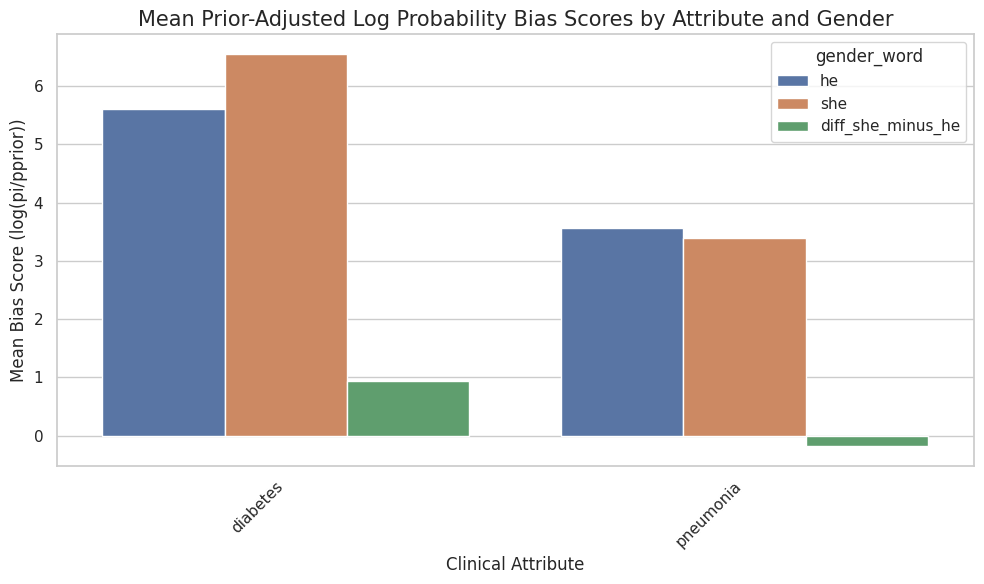


Mean Bias Scores (from template-based analysis) used for plot:
gender_word        he       she  diff_she_minus_he
attribute                                         
diabetes     5.613399  6.553048           0.939649
pneumonia    3.572433  3.391646          -0.180787


In [ ]:
# Block 15: Visualize Template-Based Bias Scores

# Ensure 'mean_scores' DataFrame from your Block 8 (template bias score analysis) is available.
# Expected structure of mean_scores (columns are 'he' and 'she'):
# gender_word        he       she
# attribute
# diabetes     5.613399  6.553048
# pneumonia    3.572433  3.391646

if 'mean_scores' in locals() and isinstance(mean_scores, pd.DataFrame) and not mean_scores.empty:
    # Prepare data for plotting
    # Ensure columns are exactly 'he' and 'she' if there was any doubt
    # This step might not be necessary if mean_scores is already correct from Block 8
    # mean_scores.columns = mean_scores.columns.str.strip().str.lower() # Example of sanitizing

    plot_data_template_bias = mean_scores.reset_index().melt(
        id_vars='attribute',
        var_name='gender_word', # This will create the column for the hue
        value_name='mean_score'
    )

    # --- Debugging Step: Inspect the hue data and palette ---
    print("Unique values in 'gender_word' column for hue:", plot_data_template_bias['gender_word'].unique())

    # Define the palette
    # Ensure keys exactly match the unique values found in plot_data_template_bias['gender_word']
    custom_palette = {}
    if 'he' in plot_data_template_bias['gender_word'].unique():
        custom_palette['he'] = 'skyblue'
    if 'she' in plot_data_template_bias['gender_word'].unique():
        custom_palette['she'] = 'lightcoral'

    # Check if all unique hue values are covered by the palette
    missing_keys = [key for key in plot_data_template_bias['gender_word'].unique() if key not in custom_palette]
    if missing_keys:
        print(f"WARNING: Palette is missing keys for these values in 'gender_word': {missing_keys}")
        # As a fallback, let Seaborn choose default colors if palette is incomplete
        # plot_palette = None
        # Or, you could add default colors for unexpected keys
        # for key in missing_keys: custom_palette[key] = 'gray' # Example fallback
        print("Attempting to plot without a complete custom palette for all hue levels.")
        plot_palette = None # Let seaborn handle it if keys are missing
    elif not custom_palette:
        print("WARNING: Custom palette is empty. This might happen if 'he' or 'she' are not in hue column. Letting Seaborn choose colors.")
        plot_palette = None
    else:
        plot_palette = custom_palette
        print(f"Using custom palette: {plot_palette}")


    plt.figure(figsize=(10, 6))
    try:
        sns.barplot(x='attribute', y='mean_score', hue='gender_word',
                    data=plot_data_template_bias,
                    palette=plot_palette) # Use the dynamically created or None palette
        plt.title('Mean Prior-Adjusted Log Probability Bias Scores by Attribute and Gender', fontsize=15)
        plt.xlabel('Clinical Attribute', fontsize=12)
        plt.ylabel('Mean Bias Score (log(pi/pprior))', fontsize=12)
        plt.xticks(rotation=45, ha="right")
        if plot_palette: # Only add legend if hue was used with a palette
            plt.legend(title='Gendered Pronoun')
        plt.tight_layout()
        plt.show()
    except ValueError as e:
        print(f"Seaborn ValueError during plotting: {e}")
        print("This might happen if 'gender_word' contains NaN or unexpected values not handled by the palette.")
        print("Data being plotted for hue:\n", plot_data_template_bias['gender_word'].value_counts(dropna=False))


    print("\nMean Bias Scores (from template-based analysis) used for plot:")
    print(mean_scores)
else:
    print("Skipping visualization for template-based bias scores: 'mean_scores' DataFrame not found or is empty.")
    print("Please ensure Block 8 (or equivalent that generates template bias mean_scores) has been run.")

## 16. Visualization: Downstream Task Performance Metrics by Gender

This set of plots visualizes key performance metrics from our downstream classification task (in-hospital mortality prediction) for each gender group ('F' and 'M'). We will plot:
-   Recall (True Positive Rate)
-   Specificity (True Negative Rate)
-   Precision (Positive Predictive Value)
-   False Positive Rate

These values are taken from the `fairness_metrics_results` dictionary generated in Block 12. This helps in visually comparing how the model performs for different groups before looking at the explicit gaps.

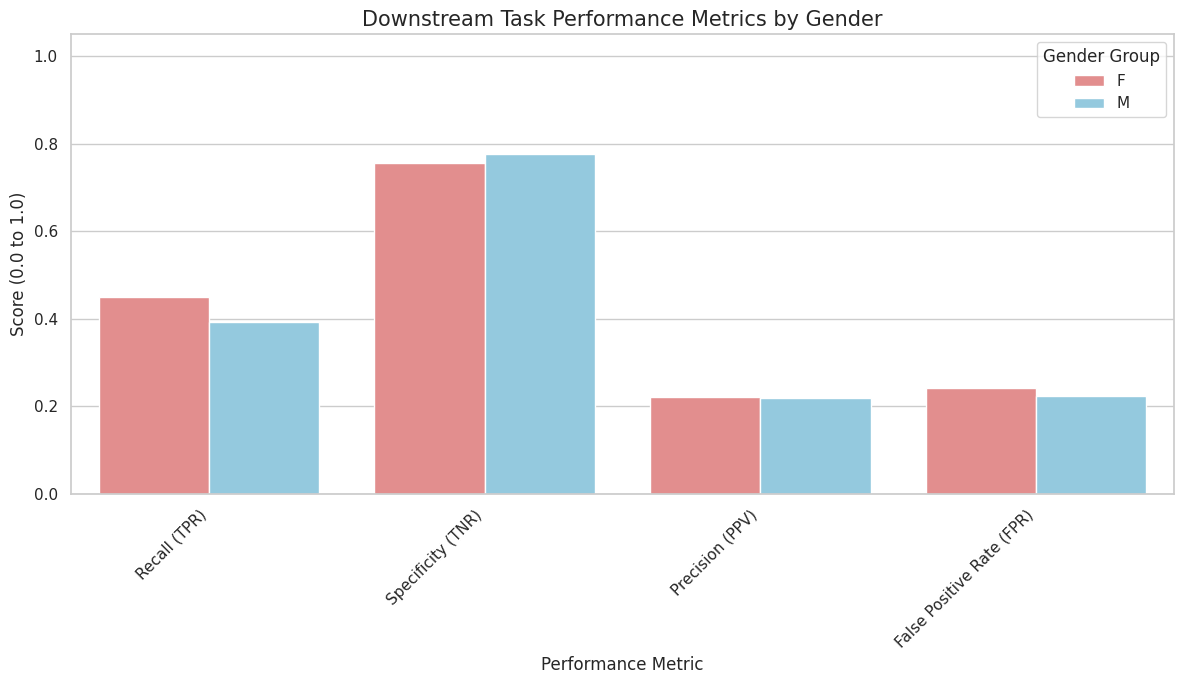


Data used for the plot (metrics per group):
                            Recall (TPR)  Specificity (TNR)  Precision (PPV)  \
Demographic Group (Gender)                                                     
F                               0.448980           0.757098         0.222222   
M                               0.391892           0.776087         0.219697   

                            False Positive Rate (FPR)  
Demographic Group (Gender)                             
F                                            0.242902  
M                                            0.223913  


In [ ]:
# Ensure 'fairness_metrics_results' dictionary from your Block 12 (downstream task fairness) is available.
# Example structure of fairness_metrics_results:
# {
#   'F': {'n_samples': 366, 'positive_prediction_rate': 0.2705, 'recall (TPR)': 0.4490, ...},
#   'M': {'n_samples': 534, 'positive_prediction_rate': 0.2472, 'recall (TPR)': 0.3919, ...}
# }

if 'fairness_metrics_results' in locals() and isinstance(fairness_metrics_results, dict) and fairness_metrics_results:
    # Convert the dictionary to a DataFrame for easier plotting
    plot_data_list = []
    for group, metrics in fairness_metrics_results.items():
        plot_data_list.append({
            'Demographic Group (Gender)': group,
            'Recall (TPR)': metrics.get('recall (TPR)', np.nan),
            'Specificity (TNR)': metrics.get('specificity (TNR)', np.nan),
            'Precision (PPV)': precision_results.get(group, np.nan), # Assuming 'precision_results' is from Block 13
            'False Positive Rate (FPR)': metrics.get('FPR', np.nan)
        })

    plot_df_metrics = pd.DataFrame(plot_data_list)

    if not plot_df_metrics.empty:
        plot_df_melted = plot_df_metrics.melt(id_vars='Demographic Group (Gender)',
                                              var_name='Metric',
                                              value_name='Score')

        plt.figure(figsize=(12, 7))
        sns.barplot(x='Metric', y='Score', hue='Demographic Group (Gender)', data=plot_df_melted, palette={'F': 'lightcoral', 'M': 'skyblue'})
        plt.title('Downstream Task Performance Metrics by Gender', fontsize=15)
        plt.xlabel('Performance Metric', fontsize=12)
        plt.ylabel('Score (0.0 to 1.0)', fontsize=12)
        plt.xticks(rotation=45, ha="right")
        plt.legend(title='Gender Group')
        plt.ylim(0, 1.05) # Ensure y-axis goes up to 1 for rates/probabilities
        plt.tight_layout()
        plt.show()

        print("\nData used for the plot (metrics per group):")
        print(plot_df_metrics.set_index('Demographic Group (Gender)'))
    else:
        print("Could not generate plot_df_metrics, possibly due to empty fairness_metrics_results.")
else:
    print("Skipping visualization for downstream task metrics: 'fairness_metrics_results' not found or is empty.")
    print("Please ensure Block 12 (downstream task fairness calculation) has been run.")
    # Define precision_results as an empty dict if it's not available to avoid NameError in the plotting block
    if 'precision_results' not in locals():
        precision_results = {}

## 17. Visualization: Downstream Task Fairness Gaps

This plot shows the calculated fairness gaps between the demographic groups (Male vs. Female, with Female as the reference group for subtraction: Metric_Male - Metric_Female) for the downstream task. The gaps visualized are:
-   Demographic Parity Gap
-   Recall Gap (Equality of Opportunity for Positives)
-   Specificity Gap (Equality of Opportunity for Negatives)
-   False Positive Rate (FPR) Gap
-   Predictive Equality (Precision) Gap (from our extension)

These values are taken from the `fairness_gaps_report` dictionary generated in Block 12 and updated in Block 13. A gap close to zero indicates more fairness according to that specific metric.

In [2]:
# In Block 17, replace the text annotation loop with this:

if gap_names:
    plot_df_gaps = pd.DataFrame({'Fairness Gap Type': gap_names, 'Gap Value': gap_values})

    plt.figure(figsize=(12, 8)) # Slightly wider and taller for clarity
    barplot = sns.barplot(
        x='Gap Value',
        y='Fairness Gap Type',
        data=plot_df_gaps,
        hue='Fairness Gap Type',
        palette="coolwarm",
        dodge=False,
        legend=False
    )
    plt.title(f'Downstream Task Fairness Gaps ({fairness_gaps_report.get("comparison", "Group1 vs Group0")})', fontsize=16)
    plt.xlabel('Gap Value (Group_M - Group_F)', fontsize=13)
    plt.ylabel('Type of Fairness Gap', fontsize=13)
    plt.axvline(0, color='black', lw=1, ls='--') # Made line slightly thicker

    # Determine appropriate x-axis limits to give space for text
    min_val = plot_df_gaps['Gap Value'].min()
    max_val = plot_df_gaps['Gap Value'].max()
    padding = (max_val - min_val) * 0.15 # Add 15% padding on each side for text
    plt.xlim(min_val - padding, max_val + padding)

    for index, row in plot_df_gaps.iterrows():
        text_val = f"{row['Gap Value']:.4f}"
        bar_val = row['Gap Value']

        # Place text inside the bar, near the end, or just outside if bar is too small
        if abs(bar_val) < (max_val - min_val) * 0.05: # If bar is very small
             # Place text outside very small bars
            text_x = bar_val + np.sign(bar_val) * (max_val-min_val) * 0.02 # Small offset outside
            ha = 'left' if bar_val >= 0 else 'right'
        elif bar_val >= 0:
            text_x = bar_val - (max_val - min_val) * 0.015 # Inside, near right end
            ha = 'right'
        else: # bar_val < 0
            text_x = bar_val + (max_val - min_val) * 0.015 # Inside, near left end
            ha = 'left'

        plt.text(text_x, # x-coordinate for text
                 index,    # y-coordinate (bar index)
                 text_val,
                 color='black',
                 ha=ha,
                 va='center',
                 fontsize=9)

    plt.tight_layout() # Apply after all elements are added
    plt.show()

    print("\nData used for fairness gap plot:")
    print(plot_df_gaps)
# ... rest of your code ...

NameError: name 'gap_names' is not defined